<img src="https://cdn.bulbagarden.net/upload/2/21/001Bulbasaur.png" alt="Bulbasaur Pic" style="width: 256px;"/>

# Generate Card Images

1. Download Ken Sugimori art from [bulbapedia](https://archives.bulbagarden.net/wiki/Category:Ken_Sugimori_Pok%C3%A9mon_artwork), augment
2. Use [DRAGAN](https://github.com/kodalinaveen3/DRAGAN) to generate new pokemon art
3. Use PIL to combine random char-rnn generated card properties and DRAGAN generated art, using [templates](https://pokemoncardresources.deviantart.com/gallery/51274687/Resources-Classic)

## Download from Bulbapedia

## Download from pkparaiso

In [ ]:
import glob, shutil, json, requests, collections
data_dir = '/home/ubuntu/fastai-data/pokemon_img'

for gif in glob.glob(os.path.join(data_dir, 'gifs', '*.gif')):
    name = gif.split('/')[-1][:-4].split('-')[0]
    response = requests.get('https://api.pokemontcg.io/v1/cards?name={}&supertype=pokemon'.format(name))
    try:
        types = json.loads(response.content.decode('utf-8'))['cards'][-1]['types'][0]
        for png in glob.glob(os.path.join(data_dir, 'pngs', '{}*.png'.format(name))):
            os.makedirs(os.path.join(data_dir, 'train', types), exist_ok=True)
            shutil.move(png, os.path.join(data_dir, 'train', types))
            if types == 'Lightning':
                print(gif)
    except:
        print(name)

## Create GAN

- Basically copied [makegirlsmoe](https://makegirlsmoe.github.io/assets/pdf/technical_report.pdf)'s architecture and [pytorch DRAGAN](https://github.com/jfsantos/dragan-pytorch/blob/master/dragan.py) / [keras WGAN-GP](https://github.com/farizrahman4u/keras-contrib/blob/master/examples/improved_wgan.py)'s code, because I don't know what I'm doing that well.
- GANs (Generative Adverserial Networks) use a competition between a generator and discriminator neural network to gradually make the generator output match existing samples
    - GANs are inefficient in pure keras - probably good to learn pytorch sometime
    - also don't combine learning a new generator architecture (resnet), a new concept (GANs), and an experimental GAN architecture (DRAGAN) at the same time next time. Especially do not do this all while using the entire data set for training rather than samples.
    - Every batch, first train the discriminator network to correctly classify real and generated images
        - discriminator is a convolutional image classifier network that classifies images as real or fake (binary).
        - discriminator network is actually stacked generator and discriminator, but only discriminator weights are being trained. Input a batch of real images and a batch of noise, feed the noise through the generator and then through the discriminator (real images go straight to discriminator), and optimize discriminator to classify real images as real and generated images as fake.
    - then, train the generator network to fool the discriminator network
        - generator takes noise vector and generates image. In this case we reshape a noise vector into an image, use a dense layer to increase a low resolution image's depth (# of channels), convolutional layers to create features, and pixel shuffles to increase resolution by decreasing depth, until we end up with an appropriate image.
        - generator network is also stacked generator and discriminator, but only the generator weights are trained now. Input a batch of noise, feed it through the generator and discriminator, and optimize the generator so the discriminator classifies the generated images as real (by feeding it the opposite labels).
    - Overall discriminator loss should be lower than generator loss (so generator always has a somewhat accurate goal);  about 0.1-1 discriminator loss and 2-7 generator loss may be good. Loss should not converge but reach equilibrium, as increasing discriminator accuracy leads to better generator which lowers discriminator accuracy and vice versa.
    - DRAGAN adds a gradient penalty to the discriminator to make it easier to train. Creates perturbed images (adding noise vectors to real images) and adds a penalty to the loss function proportional to the gradient of the discriminator at those perturbed images (should make discriminator more linear?)
    - GAN tricks is very helpful, and follow pytorch DRAGAN implementation as closely as possible
        - Remember example implementations and overview papers often don't show things like dropout
- Resnets use skip connections to make networks more linear and help with deep networks
    - resblocks have skip connections, where output from earlier layer is elementwise summed with output from later layer. See resnet paper. This helps make deep networks more linear and generalizable
    - pixel shuffle is used to increase resolution, by making an image tensor wider (higher res) but shallower (fewer channels). See [subpixel](https://github.com/tetrachrome/subpixel)

In [1]:
# imports
from itertools import product

from keras import backend as K
from keras.models import Model
from keras.initializers import *
from keras.layers import *
from keras.engine.topology import Layer
from keras.optimizers import Adam
import itertools, os
import numpy as np

Using TensorFlow backend.


- Defines some layer functions for use in generator and discriminator networks
- pixel shuffle from https://github.com/titu1994/Super-Resolution-using-Generative-Adversarial-Networks/blob/master/models.py
- Appears that changing to upscale + convolution instead of deconvolution (convolution + pixel shuffle) improves diversity of results as well as eliminates checkerboard artifacts?

In [4]:
# residual block for generative network
def g_resblock(x, filters=32):
    skip = x
    
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, skip])
    
    return x

# residual block for discriminator network
def d_resblock(x, filters=32, strides=1):
    skip = x
    
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(filters, 3, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(filters, 3, padding='same', strides=strides)(x)
    x = Add()([x, skip])
    
    return x

# superresolution CNN
def sp_cnn(x, filters=32):
    #x = Conv2D(256, 3, padding='same')(x)
    #x = PixelShuffle(2, 64)(x)
    x = UpSampling2D()(x)
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    
    return x

- Creates a super-resolution resnet like generator model, and a resnet discriminator model, approx. according to the [technical report](https://makegirlsmoe.github.io/assets/pdf/technical_report.pdf)
- generator model has less resblocks to reduce complexity and make it not converge as fast
- looks more random if activations are removed from sp_cnn blocks?
- Using tanh instead of relu and family seems to make things better as well?
- Adding gaussian noise to input of discriminator might stabilize training

In [5]:
# generator network architecture
def get_generator(x, y, dim=16, depth=64):
    y = Dense(128)(y)
    x = Multiply()([x, y]) # combine noise and class
    x = Dense(dim*dim*depth)(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Reshape((dim, dim, depth))(x)
    x = Dropout(0.5)(x)
    skip = x = Conv2D(1, 1, padding='same')(x)

    for i in range(15):
        x = g_resblock(x)
        
    x = Conv2D(32, 3, padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Add()([x, skip])
    
    for i in range(3):
        x = sp_cnn(x)
    
    x = Conv2D(3, 9, padding='same')(x)
    x = Activation('tanh')(x)
    
    return x

# discriminator network architecture
def get_discriminator(x):
    x = Conv2D(32, 4, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)
    
    for i in range(3):
        x = d_resblock(x, filters=2**(5+i))
        x = d_resblock(x, filters=2**(5+i))
        if (i < 2):
            x = Conv2D(2**(6+i), 4, strides=2, padding='same')(x)
        else:
            x = Dropout(0.1)(x)
            x = Conv2D(2**(6+i), 3, strides=2, padding='same')(x)
        x = LeakyReLU(alpha=0.2)(x)

    x = Flatten()(x)
    y = Dense(11)(x) # classify type of pokemon
    y = Activation('softmax')(y)
    x = Dense(1)(x) # classify real or fake
    x = Activation('sigmoid')(x)
    
    return (x, y)

In [6]:
g_input = Input(shape=[128], name='noise')
g_input2 = Input(shape=[11], name='type')
generator = Model(inputs=[g_input, g_input2], outputs=get_generator(g_input, g_input2))

g_test = generator.predict({'noise': np.random.normal(size=(8, 128), scale=1),
                            'type': np.eye(11)[np.random.choice(11, 8)]})
print('max: {} min: {} mean: {}'.format(np.max(g_test), np.min(g_test), np.mean(g_test)))

max: 0.08837207406759262 min: -0.17802880704402924 mean: -0.024924026802182198


In [7]:
d_input = Input(shape=[128, 128, 3], name='images')
discriminator = Model(inputs=d_input, outputs=get_discriminator(d_input))

d_test, d_test2 = discriminator.predict({'images': g_test})
print('max: {} min: {} mean: {}'.format(np.max(d_test), np.min(d_test), np.mean(d_test)))

max: 0.5036664009094238 min: 0.5020673871040344 mean: 0.5031316876411438


- Converts generator and discriminator networks into the form required for DRAGAN training
    - adds nontrainable discriminator network layers to generator, to allow us to maximize discriminator loss
    - adds other loss functions and inputs to discriminator network, so it trains on real examples as well as generated examples, and uses the DRAGAN gradient penalty
    - generator should have lower learning rate than discriminator

In [8]:
batch_size = 32



# discriminator_model trains discriminator with real and generated images
for layer in discriminator.layers:
    layer.trainable = True
for layer in generator.layers:
    layer.trainable = False
discriminator.trainable = True
generator.trainable = False

# blog article suggests perturbing in all directions (-1 to 1 rather than 0 to 1)
def perturb(input, c=0.1):
    b, row, col, k = batch_size, 128, 128, 3 #input.shape
    alpha = K.repeat_elements(K.repeat_elements(K.repeat_elements(
        K.random_uniform((b, 1, 1, 1), 0, 1), row, 1), col, 2), k, 3)
    x_hat = alpha*input + (1-alpha)*(input + c * K.std(input) * K.random_uniform((b, row, col, k), -1, 1))
    return x_hat

# inputs for stacked generator/discriminator
imgs = Input(shape=[128, 128, 3]) # real mini-batch
p_imgs = Lambda(perturb, output_shape=K.int_shape(imgs)[1:])(imgs) # perturbed mini-batch
noise = Input(shape=[128])
types = Input(shape=[11])

# from keras WGAN-GP, though called with randomly perturbed inputs rather than averaged inputs
def gradient_penalty(y_true, y_pred, x_hat=p_imgs):
    gradients = K.gradients(K.sum(y_pred), x_hat)
    gradient_l2_norm = K.sqrt(K.sum(K.square(gradients), axis=[1,2,3]))
    gradient_penalty = K.mean(K.square(gradient_l2_norm - 1))
    return gradient_penalty

# discriminator model with inputs both real and generated images
discriminator_model = Model(inputs=[imgs, noise, types],
                    outputs=discriminator(imgs)+discriminator(generator([noise, types]))+discriminator(p_imgs))
discriminator_model.compile(optimizer=Adam(3e-4),
                    loss=['binary_crossentropy', 'categorical_crossentropy',
                          'binary_crossentropy', 'categorical_crossentropy',
                          gradient_penalty, gradient_penalty],
                    loss_weights=[1.8, 0.2, 0.9, 0.1, 1.0, 0])

#test2 = discriminator_model.predict([generator.predict(np.random.normal(size=(4, 128))),
#                                     np.random.normal(size=(4, 128))])
#print('max: {} min: {} mean: {}'.format(np.max(test2[1]), np.min(test2[1]), np.mean(test2[1])))
discriminator_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 11)           0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128, 128, 3)  2498308     input_2[0][0]                    
                                                                 input_3[0][0]                    
__________

In [9]:
# generator_model trains generator to create image, optimizes to maximize discriminator loss
for layer in discriminator.layers:
    layer.trainable = False
for layer in generator.layers:
    layer.trainable = True
discriminator.trainable = False
generator.trainable = True

generator_model = Model(inputs=[noise, types], outputs=discriminator(generator([noise, types])))
generator_model.compile(optimizer=Adam(1e-3),
                        loss=['binary_crossentropy', 'categorical_crossentropy'],
                        loss_weights=[0.9, 0.1])

#test = generator_model.predict(np.random.normal(size=(4, 256)))
#print('max: {} min: {} mean: {}'.format(np.max(test), np.min(test), np.mean(test)))
generator_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 11)           0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128, 128, 3)  2498308     input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 [(None, 1), (None, 1 1432428     model_1[2][0]                    
Total para

## Training Your DRAGAN

In [10]:
from keras.preprocessing import image
from matplotlib import pyplot as plt
import numpy as np
import random, os

# Instantiate plotting tool
%matplotlib inline

In [11]:
def plots(ims, figsize=(12,6), rows=2, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [12]:
data_dir = '/home/ubuntu/fastai-data/pokemon_img'
train_path = os.path.join(data_dir, 'train')
temp_path = os.path.join(data_dir, 'temp')
result_path = os.path.join(data_dir, 'results')

Found 38376 images belonging to 11 classes.
max: 0.99609375 min: -0.99609375 mean: 0.771446704864502


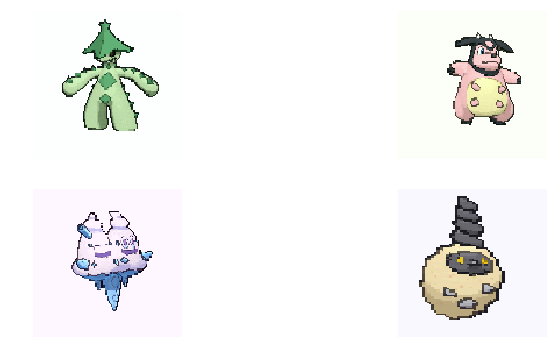

In [13]:
def get_batches(dirname, temp_dir=None, shuffle=True, batch_size=batch_size):
    gen = image.ImageDataGenerator(preprocessing_function=lambda x: (x - 127.5)/128,
                                  horizontal_flip=True,
                                  width_shift_range=0.09,
                                  height_shift_range=0.09,
                                  zoom_range=[1.1, 1.65],
                                  shear_range=0.05,
                                  fill_mode='constant',
                                  cval=255,
                                  channel_shift_range=8)
    return gen.flow_from_directory(dirname,
                                  target_size=(128,128),
                                  class_mode='categorical',
                                  color_mode='rgb',
                                  shuffle=shuffle,
                                  save_to_dir=temp_dir,
                                  batch_size=batch_size)

#batches = get_batches(train_path, temp_dir=temp_path)
batches = get_batches(train_path)

for i in range(5):
    batch, labels = next(batches)
print('max: {} min: {} mean: {}'.format(np.max(batch), np.min(batch), np.mean(batch)))
plots([image.load_img(os.path.join(temp_path, img)) for img in random.sample(os.listdir(temp_path), 4)])

In [14]:
from PIL import Image

def tile_images(image_stack):
    assert len(image_stack.shape) == 4
    image_list = [image_stack[i, :, :, :] for i in range(image_stack.shape[0])]
    #image_list = [image_stack[i, :, :] for i in range(image_stack.shape[0])]
    tiled_images = np.concatenate(image_list, axis=1)
    #tiled_images = np.swapaxes(tiled_images, 0, 2)
    return tiled_images

def generate_images(generator, output_dir, epoch):
    test_image_stack = generator.predict([np.random.normal(size=(8, 128), scale=1), np.eye(11)[:8]]) 
    test_image_stack = (test_image_stack * 127.5) + 127.5
    test_image_stack = np.squeeze(np.round(test_image_stack).astype(np.uint8))
    tiled_output = tile_images(test_image_stack)
    tiled_output = Image.fromarray(tiled_output, mode='RGB')
    outfile = os.path.join(output_dir, 'epoch_{}.png'.format(epoch))
    tiled_output.save(outfile)

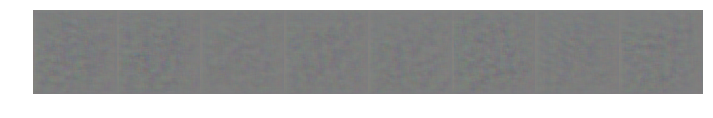

In [15]:
test_image_stack = generator.predict([np.random.normal(size=(8, 128), scale=1), np.eye(11)[np.random.choice(11, 8)]])
test_image_stack = (test_image_stack * 127.5) + 127.5
test_image_stack = np.squeeze(np.round(test_image_stack).astype(np.uint8))
tiled_output = tile_images(test_image_stack)
tiled_output = Image.fromarray(tiled_output, mode='RGB')
outfile = os.path.join(temp_path, 'perturb_test.png')
tiled_output.save(outfile)

plots([image.load_img(outfile)])

- Concensus from [Animeface-GAN](https://github.com/forcecore/Keras-GAN-Animeface-Character) and others seems to be generator loss of 2-4 and discriminator loss around 0.3 is good
- One sided label noising and both sided label smoothing for discriminator, no smoothing or noising for generator seems to work well for me

In [16]:
sample_period = int(38376 / batch_size / 5)
save_period = int(38376 / batch_size / 30)
true_positive_y = np.ones((batch_size, 1))
true_negative_y = np.zeros((batch_size, 1))
dummy_y = np.zeros((batch_size, 1)) + 0.5

epoch = 0
if epoch > 0:
    generator_model.load_weights(os.path.join(result_path, 'gan_g_weights{}.h5'.format(epoch)))
    discriminator_model.load_weights(os.path.join(result_path, 'gan_d_weights{}.h5'.format(epoch)))
    """
    discriminator_loss = np.loadtxt(os.path.join(result_path, 'gan_d_loss_history.csv'))
    discriminator_loss = list(np.broadcast_to(
        np.expand_dims(discriminator_loss, axis=1),(discriminator_loss.shape[0], 4)))
    generator_loss =  list(np.loadtxt(os.path.join(result_path, 'gan_g_loss_history.csv')))
    batch_num = len(discriminator_loss) + 1
    """
    discriminator_loss = []
    generator_loss = []
    batch_num = 0
else:
    discriminator_loss = []
    generator_loss = []
    batch_num = 0

epoch += 1
print('Epoch ' + str(epoch) + '\n')
for imgs, types in batches:
    
    # save weights and generate sample images every so often
    if batch_num % sample_period == 0 and batch_num > 1:
        generate_images(generator, result_path, epoch)
        if generator_loss[-1][0] > 0.5:
            try:
                generator_model.save_weights(os.path.join(result_path, 'gan_g_weights{}.h5'.format(epoch)))
                discriminator_model.save_weights(os.path.join(result_path, 'gan_d_weights{}.h5'.format(epoch)))
            except:
                print('Weights could not be saved')
        epoch += 1
        print('\nEpoch ' + str(epoch))

    if batch_num % save_period == 0 and batch_num > 1:
        print('D. Loss | Total: ' + str(discriminator_loss[-1][0])
              + ' | Real: ' + str(discriminator_loss[-1][1])
              + ' | Fake: ' + str(discriminator_loss[-1][3])
              + ' | Penalty: ' + str(discriminator_loss[-1][5])
              + ' | Categorical: '+str(discriminator_loss[-1][2]))
        np.savetxt(os.path.join(result_path, 'gan_d_loss_history.csv'), np.asarray(discriminator_loss)[:,0])
        
        print('G. Loss | Total: ' + str(generator_loss[-1][0])
             + ' | Real/Fake: ' +  str(generator_loss[-1][1])
             + ' | Categorical: ' + str(generator_loss[-1][2]))
        np.savetxt(os.path.join(result_path, 'gan_g_loss_history.csv'), np.asarray(generator_loss)[:,0])
    
    if len(imgs) == batch_size:
        # smooth positive labels only
        positive_y = np.random.uniform(0.85, 1.1, size=(batch_size, 1))
        negative_y = np.zeros((batch_size, 1))+0.05
    
        # train discriminator with real, generated, and perturbed images
        noise = np.random.normal(size=(batch_size, 128), scale=1)
        gen_types = np.eye(11)[np.random.choice(11, batch_size)]
        discriminator_loss.append(
            discriminator_model.train_on_batch([imgs, noise, gen_types],
                                               [positive_y, types, negative_y, gen_types, dummy_y, gen_types]))

        # train generator to maximize discriminator loss
        noise2 = np.random.normal(size=(batch_size, 128), scale=1)
        gen_types2 = np.eye(11)[np.random.choice(11, batch_size)]
        generator_loss.append(
            generator_model.train_on_batch([noise2, gen_types2], [positive_y, gen_types2]))
        
    batch_num += 1

Epoch 1



/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


ResourceExhaustedError: OOM when allocating tensor with shape[32,64,64,32]
	 [[Node: model_2_2/dropout_2/cond/mul = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/Adam/gradients/Switch_10:1, model_2_2/dropout_2/cond/mul/y)]]
	 [[Node: loss/model_2_loss/Mean_3/_881 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_11506_loss/model_2_loss/Mean_3", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'model_2_2/dropout_2/cond/mul', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-c12ce5e8ca6a>", line 36, in <module>
    outputs=discriminator(imgs)+discriminator(generator([noise, types]))+discriminator(p_imgs))
  File "/usr/local/lib/python3.5/dist-packages/keras/engine/topology.py", line 603, in __call__
    output = self.call(inputs, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/keras/engine/topology.py", line 2061, in call
    output_tensors, _, _ = self.run_internal_graph(inputs, masks)
  File "/usr/local/lib/python3.5/dist-packages/keras/engine/topology.py", line 2212, in run_internal_graph
    output_tensors = _to_list(layer.call(computed_tensor, **kwargs))
  File "/usr/local/lib/python3.5/dist-packages/keras/layers/core.py", line 117, in call
    training=training)
  File "/usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py", line 2753, in in_train_phase
    x = switch(training, x, alt)
  File "/usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py", line 2688, in switch
    else_expression_fn)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/util/deprecation.py", line 316, in new_func
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/control_flow_ops.py", line 1855, in cond
    orig_res_t, res_t = context_t.BuildCondBranch(true_fn)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/control_flow_ops.py", line 1725, in BuildCondBranch
    original_result = fn()
  File "/usr/local/lib/python3.5/dist-packages/keras/layers/core.py", line 115, in dropped_inputs
    seed=self.seed)
  File "/usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py", line 3013, in dropout
    return tf.nn.dropout(x * 1., retain_prob, noise_shape, seed=seed)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_ops.py", line 894, in binary_op_wrapper
    return func(x, y, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_ops.py", line 1117, in _mul_dispatch
    return gen_math_ops._mul(x, y, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_math_ops.py", line 2726, in _mul
    "Mul", x=x, y=y, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[32,64,64,32]
	 [[Node: model_2_2/dropout_2/cond/mul = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/Adam/gradients/Switch_10:1, model_2_2/dropout_2/cond/mul/y)]]
	 [[Node: loss/model_2_loss/Mean_3/_881 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_11506_loss/model_2_loss/Mean_3", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


## Compare with hypergan card images because keras is soooo slow

- Seriously, raw tensorflow is like at least 10 times faster than keras for this. Also keras keeps making me tweak the hyperparameters every few epochs to avoid nans. I really should learn pytorch soon. Maybe my generator and discriminator architectures are overkill, but the double evaluation for each model and the gradient penalty are very inefficient in keras.

- Looks like hypergan isn't very effective for this task either - discriminator or generator loss goes to 0 after just a few epochs, no matter what hyperparameters I try. May need more data augmentation, and it's easier to do that in keras.